In [21]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

In [22]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
csv_path = r'F:\dataset\merged csv\dataset_balance.csv'
data = pd.read_csv(csv_path)
data['label'] = data['label'].map({'DDoS-SlowLoris': 1, 'BenignTraffic': 0})
data = data.dropna(subset=['label'])

X_columns = [col for col in data.columns if col != 'label']
X = data[X_columns].astype('float32')
y = data['label'].astype('int32')

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

split_idx = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [24]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor([1.0, class_weights[1]], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])

In [26]:
input_dim = X_train.shape[1]
model = OptimizedMLP(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
batch_size = 128

X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
epoch_time_list = [None] * num_epochs

start_train_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            y_true = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y_true, preds)
            times += 1

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_accuracy / times
    epoch_duration = time.time() - epoch_start_time

    loss_list[epoch] = epoch_loss
    acc_list[epoch] = epoch_acc
    epoch_time_list[epoch] = epoch_duration

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {epoch_duration:.4f}s")

    pbar.update(1)

end_train_time = time.time()
training_duration = end_train_time - start_train_time

pbar.reset()

  1%|          | 1/100 [00:00<01:09,  1.43it/s]

Epoch [1/100], Loss: 0.1243, Accuracy: 0.9608, Time: 0.6993s


  2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

Epoch [2/100], Loss: 0.0074, Accuracy: 0.9992, Time: 0.7123s


  3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

Epoch [3/100], Loss: 0.0065, Accuracy: 0.9994, Time: 0.6947s


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

Epoch [4/100], Loss: 0.0063, Accuracy: 0.9994, Time: 0.7313s


  5%|▌         | 5/100 [00:03<01:07,  1.42it/s]

Epoch [5/100], Loss: 0.0062, Accuracy: 0.9994, Time: 0.6907s


  6%|▌         | 6/100 [00:04<01:06,  1.41it/s]

Epoch [6/100], Loss: 0.0061, Accuracy: 0.9994, Time: 0.7099s


  7%|▋         | 7/100 [00:04<01:05,  1.42it/s]

Epoch [7/100], Loss: 0.0059, Accuracy: 0.9994, Time: 0.6952s


  8%|▊         | 8/100 [00:05<01:04,  1.43it/s]

Epoch [8/100], Loss: 0.0057, Accuracy: 0.9994, Time: 0.6897s


  9%|▉         | 9/100 [00:06<01:03,  1.43it/s]

Epoch [9/100], Loss: 0.0053, Accuracy: 0.9994, Time: 0.6942s


 10%|█         | 10/100 [00:07<01:02,  1.44it/s]

Epoch [10/100], Loss: 0.0051, Accuracy: 0.9994, Time: 0.6892s


 11%|█         | 11/100 [00:07<01:02,  1.42it/s]

Epoch [11/100], Loss: 0.0051, Accuracy: 0.9993, Time: 0.7273s


 12%|█▏        | 12/100 [00:08<01:01,  1.42it/s]

Epoch [12/100], Loss: 0.0046, Accuracy: 0.9994, Time: 0.7002s


 13%|█▎        | 13/100 [00:09<01:00,  1.43it/s]

Epoch [13/100], Loss: 0.0047, Accuracy: 0.9994, Time: 0.6927s


 14%|█▍        | 14/100 [00:09<01:00,  1.43it/s]

Epoch [14/100], Loss: 0.0045, Accuracy: 0.9994, Time: 0.6902s


 15%|█▌        | 15/100 [00:10<01:00,  1.41it/s]

Epoch [15/100], Loss: 0.0043, Accuracy: 0.9994, Time: 0.7288s


 16%|█▌        | 16/100 [00:11<00:59,  1.42it/s]

Epoch [16/100], Loss: 0.0043, Accuracy: 0.9995, Time: 0.6907s


 17%|█▋        | 17/100 [00:11<00:58,  1.43it/s]

Epoch [17/100], Loss: 0.0042, Accuracy: 0.9995, Time: 0.6907s


 18%|█▊        | 18/100 [00:12<00:57,  1.42it/s]

Epoch [18/100], Loss: 0.0043, Accuracy: 0.9995, Time: 0.7118s


 19%|█▉        | 19/100 [00:13<00:57,  1.41it/s]

Epoch [19/100], Loss: 0.0041, Accuracy: 0.9995, Time: 0.7203s


 20%|██        | 20/100 [00:14<00:57,  1.40it/s]

Epoch [20/100], Loss: 0.0042, Accuracy: 0.9994, Time: 0.7299s


 21%|██        | 21/100 [00:14<00:56,  1.40it/s]

Epoch [21/100], Loss: 0.0042, Accuracy: 0.9994, Time: 0.7184s


 22%|██▏       | 22/100 [00:15<00:55,  1.40it/s]

Epoch [22/100], Loss: 0.0041, Accuracy: 0.9994, Time: 0.7049s


 23%|██▎       | 23/100 [00:16<00:54,  1.41it/s]

Epoch [23/100], Loss: 0.0041, Accuracy: 0.9994, Time: 0.7028s


 24%|██▍       | 24/100 [00:16<00:54,  1.41it/s]

Epoch [24/100], Loss: 0.0042, Accuracy: 0.9993, Time: 0.7102s


 25%|██▌       | 25/100 [00:17<00:54,  1.39it/s]

Epoch [25/100], Loss: 0.0042, Accuracy: 0.9992, Time: 0.7434s


 26%|██▌       | 26/100 [00:18<00:53,  1.39it/s]

Epoch [26/100], Loss: 0.0043, Accuracy: 0.9994, Time: 0.7133s


 27%|██▋       | 27/100 [00:19<00:52,  1.40it/s]

Epoch [27/100], Loss: 0.0043, Accuracy: 0.9993, Time: 0.7028s


 28%|██▊       | 28/100 [00:19<00:51,  1.41it/s]

Epoch [28/100], Loss: 0.0042, Accuracy: 0.9994, Time: 0.7023s


 29%|██▉       | 29/100 [00:20<00:50,  1.41it/s]

Epoch [29/100], Loss: 0.0041, Accuracy: 0.9995, Time: 0.7058s


 30%|███       | 30/100 [00:21<00:49,  1.42it/s]

Epoch [30/100], Loss: 0.0044, Accuracy: 0.9992, Time: 0.6937s


 31%|███       | 31/100 [00:21<00:48,  1.42it/s]

Epoch [31/100], Loss: 0.0041, Accuracy: 0.9993, Time: 0.6943s


 32%|███▏      | 32/100 [00:22<00:48,  1.40it/s]

Epoch [32/100], Loss: 0.0041, Accuracy: 0.9994, Time: 0.7364s


 33%|███▎      | 33/100 [00:23<00:47,  1.40it/s]

Epoch [33/100], Loss: 0.0041, Accuracy: 0.9995, Time: 0.7123s


 34%|███▍      | 34/100 [00:24<00:47,  1.40it/s]

Epoch [34/100], Loss: 0.0045, Accuracy: 0.9990, Time: 0.7138s


 35%|███▌      | 35/100 [00:24<00:47,  1.38it/s]

Epoch [35/100], Loss: 0.0041, Accuracy: 0.9993, Time: 0.7504s


 36%|███▌      | 36/100 [00:25<00:46,  1.39it/s]

Epoch [36/100], Loss: 0.0045, Accuracy: 0.9992, Time: 0.7042s


 37%|███▋      | 37/100 [00:26<00:45,  1.38it/s]

Epoch [37/100], Loss: 0.0043, Accuracy: 0.9993, Time: 0.7335s


 38%|███▊      | 38/100 [00:26<00:44,  1.39it/s]

Epoch [38/100], Loss: 0.0043, Accuracy: 0.9993, Time: 0.7114s


 39%|███▉      | 39/100 [00:27<00:43,  1.40it/s]

Epoch [39/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6982s


 40%|████      | 40/100 [00:28<00:42,  1.41it/s]

Epoch [40/100], Loss: 0.0043, Accuracy: 0.9993, Time: 0.7033s


 41%|████      | 41/100 [00:29<00:41,  1.41it/s]

Epoch [41/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6972s


 42%|████▏     | 42/100 [00:29<00:41,  1.41it/s]

Epoch [42/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.7148s


 43%|████▎     | 43/100 [00:30<00:40,  1.41it/s]

Epoch [43/100], Loss: 0.0039, Accuracy: 0.9994, Time: 0.7013s


 44%|████▍     | 44/100 [00:31<00:39,  1.42it/s]

Epoch [44/100], Loss: 0.0041, Accuracy: 0.9993, Time: 0.6912s


 45%|████▌     | 45/100 [00:31<00:39,  1.39it/s]

Epoch [45/100], Loss: 0.0040, Accuracy: 0.9994, Time: 0.7555s


 46%|████▌     | 46/100 [00:32<00:40,  1.35it/s]

Epoch [46/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.7918s


 47%|████▋     | 47/100 [00:33<00:38,  1.37it/s]

Epoch [47/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.7103s


 48%|████▊     | 48/100 [00:34<00:38,  1.35it/s]

Epoch [48/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.7529s


 49%|████▉     | 49/100 [00:34<00:37,  1.37it/s]

Epoch [49/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.7053s


 50%|█████     | 50/100 [00:35<00:36,  1.38it/s]

Epoch [50/100], Loss: 0.0039, Accuracy: 0.9992, Time: 0.7097s


 51%|█████     | 51/100 [00:36<00:35,  1.38it/s]

Epoch [51/100], Loss: 0.0041, Accuracy: 0.9994, Time: 0.7303s


 52%|█████▏    | 52/100 [00:37<00:34,  1.39it/s]

Epoch [52/100], Loss: 0.0037, Accuracy: 0.9994, Time: 0.6988s


 53%|█████▎    | 53/100 [00:37<00:33,  1.40it/s]

Epoch [53/100], Loss: 0.0037, Accuracy: 0.9995, Time: 0.6957s


 54%|█████▍    | 54/100 [00:38<00:32,  1.41it/s]

Epoch [54/100], Loss: 0.0038, Accuracy: 0.9993, Time: 0.6958s


 55%|█████▌    | 55/100 [00:39<00:32,  1.41it/s]

Epoch [55/100], Loss: 0.0039, Accuracy: 0.9993, Time: 0.7228s


 56%|█████▌    | 56/100 [00:39<00:31,  1.41it/s]

Epoch [56/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.7049s


 57%|█████▋    | 57/100 [00:40<00:30,  1.42it/s]

Epoch [57/100], Loss: 0.0037, Accuracy: 0.9993, Time: 0.6962s


 58%|█████▊    | 58/100 [00:41<00:29,  1.42it/s]

Epoch [58/100], Loss: 0.0036, Accuracy: 0.9994, Time: 0.6932s


 59%|█████▉    | 59/100 [00:41<00:28,  1.43it/s]

Epoch [59/100], Loss: 0.0040, Accuracy: 0.9994, Time: 0.6962s


 60%|██████    | 60/100 [00:42<00:28,  1.43it/s]

Epoch [60/100], Loss: 0.0040, Accuracy: 0.9994, Time: 0.6972s


 61%|██████    | 61/100 [00:43<00:27,  1.43it/s]

Epoch [61/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.6967s


 62%|██████▏   | 62/100 [00:44<00:26,  1.43it/s]

Epoch [62/100], Loss: 0.0037, Accuracy: 0.9994, Time: 0.6967s


 63%|██████▎   | 63/100 [00:44<00:25,  1.42it/s]

Epoch [63/100], Loss: 0.0039, Accuracy: 0.9992, Time: 0.7108s


 64%|██████▍   | 64/100 [00:45<00:25,  1.41it/s]

Epoch [64/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.7238s


 65%|██████▌   | 65/100 [00:46<00:24,  1.42it/s]

Epoch [65/100], Loss: 0.0039, Accuracy: 0.9994, Time: 0.6957s


 66%|██████▌   | 66/100 [00:46<00:24,  1.42it/s]

Epoch [66/100], Loss: 0.0037, Accuracy: 0.9995, Time: 0.7077s


 67%|██████▋   | 67/100 [00:47<00:23,  1.42it/s]

Epoch [67/100], Loss: 0.0039, Accuracy: 0.9993, Time: 0.7027s


 68%|██████▊   | 68/100 [00:48<00:22,  1.42it/s]

Epoch [68/100], Loss: 0.0038, Accuracy: 0.9995, Time: 0.7023s


 69%|██████▉   | 69/100 [00:48<00:21,  1.43it/s]

Epoch [69/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.6887s


 70%|███████   | 70/100 [00:49<00:20,  1.43it/s]

Epoch [70/100], Loss: 0.0039, Accuracy: 0.9994, Time: 0.6963s


 71%|███████   | 71/100 [00:50<00:20,  1.43it/s]

Epoch [71/100], Loss: 0.0037, Accuracy: 0.9993, Time: 0.6967s


 72%|███████▏  | 72/100 [00:51<00:19,  1.44it/s]

Epoch [72/100], Loss: 0.0038, Accuracy: 0.9992, Time: 0.6897s


 73%|███████▎  | 73/100 [00:51<00:18,  1.43it/s]

Epoch [73/100], Loss: 0.0038, Accuracy: 0.9993, Time: 0.6977s


 74%|███████▍  | 74/100 [00:52<00:18,  1.42it/s]

Epoch [74/100], Loss: 0.0037, Accuracy: 0.9993, Time: 0.7178s


 75%|███████▌  | 75/100 [00:53<00:17,  1.43it/s]

Epoch [75/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6917s


 76%|███████▌  | 76/100 [00:53<00:16,  1.43it/s]

Epoch [76/100], Loss: 0.0041, Accuracy: 0.9992, Time: 0.6937s


 77%|███████▋  | 77/100 [00:54<00:16,  1.43it/s]

Epoch [77/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6988s


 78%|███████▊  | 78/100 [00:55<00:15,  1.43it/s]

Epoch [78/100], Loss: 0.0037, Accuracy: 0.9993, Time: 0.6928s


 79%|███████▉  | 79/100 [00:55<00:14,  1.43it/s]

Epoch [79/100], Loss: 0.0038, Accuracy: 0.9994, Time: 0.7107s


 80%|████████  | 80/100 [00:56<00:13,  1.43it/s]

Epoch [80/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6897s


 81%|████████  | 81/100 [00:57<00:13,  1.43it/s]

Epoch [81/100], Loss: 0.0039, Accuracy: 0.9993, Time: 0.6927s


 82%|████████▏ | 82/100 [00:58<00:12,  1.44it/s]

Epoch [82/100], Loss: 0.0038, Accuracy: 0.9993, Time: 0.6937s


 83%|████████▎ | 83/100 [00:58<00:12,  1.41it/s]

Epoch [83/100], Loss: 0.0037, Accuracy: 0.9994, Time: 0.7398s


 84%|████████▍ | 84/100 [00:59<00:11,  1.42it/s]

Epoch [84/100], Loss: 0.0037, Accuracy: 0.9994, Time: 0.6908s


 85%|████████▌ | 85/100 [01:00<00:10,  1.39it/s]

Epoch [85/100], Loss: 0.0039, Accuracy: 0.9994, Time: 0.7489s


 86%|████████▌ | 86/100 [01:00<00:10,  1.38it/s]

Epoch [86/100], Loss: 0.0040, Accuracy: 0.9994, Time: 0.7368s


 87%|████████▋ | 87/100 [01:01<00:09,  1.40it/s]

Epoch [87/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.6902s


 88%|████████▊ | 88/100 [01:02<00:08,  1.41it/s]

Epoch [88/100], Loss: 0.0042, Accuracy: 0.9992, Time: 0.6962s


 89%|████████▉ | 89/100 [01:03<00:07,  1.42it/s]

Epoch [89/100], Loss: 0.0044, Accuracy: 0.9993, Time: 0.6922s


 90%|█████████ | 90/100 [01:03<00:07,  1.43it/s]

Epoch [90/100], Loss: 0.0040, Accuracy: 0.9994, Time: 0.6912s


 91%|█████████ | 91/100 [01:04<00:06,  1.42it/s]

Epoch [91/100], Loss: 0.0041, Accuracy: 0.9994, Time: 0.7047s


 92%|█████████▏| 92/100 [01:05<00:05,  1.42it/s]

Epoch [92/100], Loss: 0.0043, Accuracy: 0.9993, Time: 0.7023s


 93%|█████████▎| 93/100 [01:05<00:04,  1.41it/s]

Epoch [93/100], Loss: 0.0045, Accuracy: 0.9994, Time: 0.7293s


 94%|█████████▍| 94/100 [01:06<00:04,  1.42it/s]

Epoch [94/100], Loss: 0.0047, Accuracy: 0.9992, Time: 0.6917s


 95%|█████████▌| 95/100 [01:07<00:03,  1.42it/s]

Epoch [95/100], Loss: 0.0047, Accuracy: 0.9993, Time: 0.7098s


 96%|█████████▌| 96/100 [01:07<00:02,  1.42it/s]

Epoch [96/100], Loss: 0.0046, Accuracy: 0.9993, Time: 0.6917s


 97%|█████████▋| 97/100 [01:08<00:02,  1.43it/s]

Epoch [97/100], Loss: 0.0043, Accuracy: 0.9994, Time: 0.6912s


 98%|█████████▊| 98/100 [01:09<00:01,  1.43it/s]

Epoch [98/100], Loss: 0.0042, Accuracy: 0.9994, Time: 0.6927s


 99%|█████████▉| 99/100 [01:10<00:00,  1.41it/s]

Epoch [99/100], Loss: 0.0042, Accuracy: 0.9995, Time: 0.7365s


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.0040, Accuracy: 0.9993, Time: 0.7248s


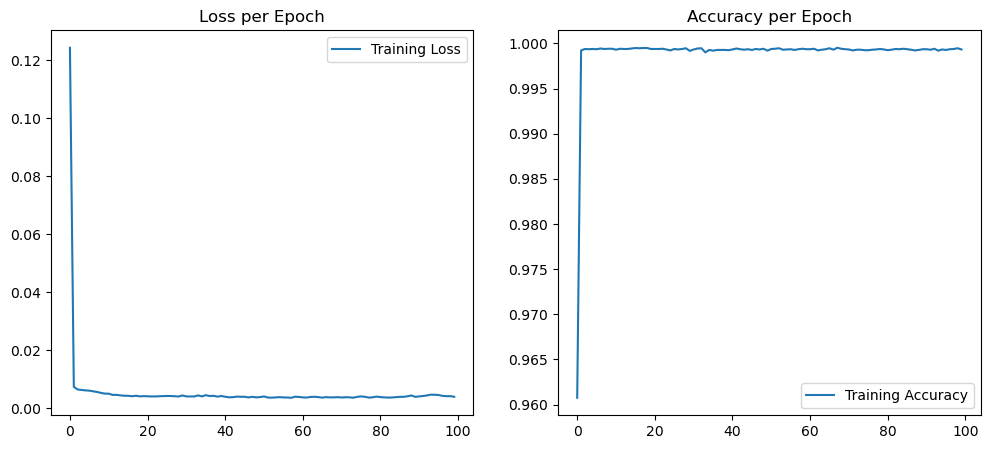

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

In [29]:
model.eval()
X_test_tensor = torch.tensor(X_test.values).float().to(device)
start_pred_time = time.time()
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float().cpu().numpy()
prediction_duration = time.time() - start_pred_time

In [30]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

# 输出结果
print("===== Final Evaluation on Test Set =====")
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(f"Training Time: {training_duration:.4f} seconds")
print(f"Prediction Time: {prediction_duration:.4f} seconds")

===== Final Evaluation on Test Set =====
Accuracy: 0.9996798634083875
Precision: 1.0
Recall: 0.9993677555321391
F1 Score: 0.9996837778012017
Training Time: 70.8388 seconds
Prediction Time: 0.0160 seconds


In [31]:
result = {
    "Model": "MLP_optimal",
    "Accuracy": float(acc),
    "Precision": float(precision),
    "Recall": float(recall),
    "F1": float(f1),
    "Train Time (s)": float(training_duration),
    "Predict Time (s)": float(prediction_duration)
}

import json
with open("result_MLP_optimal.json", "w") as f:  
    json.dump(result, f)